In [3]:
# importazione librerie necessarie
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU
from tensorflow.keras.optimizers import Nadam
from timeit import default_timer as timer

# Creazione dei dati sintetici e della matrice ricorrente

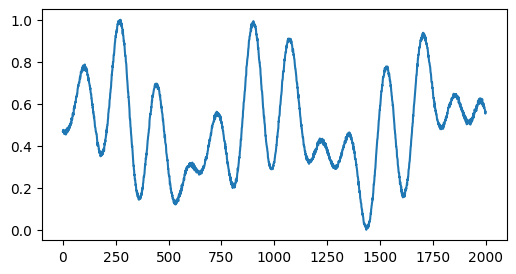

In [4]:
# configurazione parametri per generare un dataset
# utile per essere utilizzato in "sequenze temporali"
n = 2000  # 2000 esempi
test_split_point = 1600 # di cui 400 usati per la validazione del modello

t = np.arange(0, n) # lista di numeri da 0 a 1999

# costruzione del dataset
x = (np.sin(0.008 * t) + np.sin(0.03 * t) - np.sin(0.04 * t)) * 6 + (np.random.rand(n) - np.random.rand(n)) / 2

x_min = min(x)
x_max = max(x)

x = (x - x_min) / (x_max - x_min)

df = pd.DataFrame(x)


# rappresentazione grafica della distribuzione creata
plt.figure(figsize=(6, 3))
plt.plot(df)
plt.show() 


In [5]:
# conversione in array numpy
values = df.values
values.shape

(2000, 1)

In [6]:
# costruzione delle sequenze temporali
step = 100

train_x, train_y = (values[:test_split_point], step)
test_x, test_y = (values[test_split_point:], step)
train_x.shape

(1600, 1)

In [7]:
# Vedi analisi dimensionale sotto
def convert_to_matrix(data, step):

    x, y = [], []

    for i in range(len(data) - step):
        d = i + step  
        x.append(data[i:d,])
        y.append(data[d,])
        
    return np.array(x), np.array(y)

train_x, train_y = convert_to_matrix(values[:test_split_point], step)
test_x, test_y = convert_to_matrix(values[test_split_point:], step)

**Analisi dei dimensionale**

```
for i in range(len(data) - step):
        d = i + step
        x.append(data[i:d,])
        y.append(data[d,])
```

**supponiamo:**
```
- X = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
- N = 10
- step = 3
```



**allora abbiamo**

```
(N - step) = 7
Quindi il for andrà da 0 a 6 (compreso)
```

--

**i = 0 (primo)** 
```
d = 3 
x.append([0:3]) -> [0,1,2] 
y.append(data[3]) -> [3]
``` 

--

**i = 1 (secondo)**  
```
d = 4 
x.append([1:4]) -> [1,2,3] 
y.append(data[4]) -> [4]
```
--
```
...
```
--

**i = 5 (penultimo)** 
```
d = 8 
x.append([5:8]) -> [5,6,7] 
y.append(data[8]) -> [8]
```
--

**i = 6 (ultimo)** 
```
d = 9 
x.append([6:9]) -> [6,7,8] 
y.append(data[9]) -> [9]
```
--

Da cui in questo caso abbiamo
```
- len(ORIGINALE) = N

- len(RICORRENTE) = len(ORIGINALE) - T
```

--


**ACHTUNG!**
Questo è diverso dal caso visto con il notebook sulla SimpleRNN dove avevamo 

len(RICORRENTE) = (N-T+1), mentre qui abbiamo solo (N-T).



Questa differenza è dovuta al tipo di problema.



In quel caso infatti la label reale l'avevamo come y separata da y, quindi nel nuovo dataset utilizzavamo tutte le X a disposizione e mettevamo come label la Y corrispondente. 



In questo caso, invece, il valore da predirre è parte stessa del dataset X, quindi come Y passiamo il valore successivo all'ultimo passato come X.



Non possiamo mettere l'ultimo valore quindi, perché non avremmo alrimenti un'etichetta da mettere. L'ultimo valore in questo caso lo utilizziamo solo come etichetta

In [8]:
print('Shape addestramento   x', train_x.shape, '   y', train_y.shape)
print('Shape test            x', test_x.shape, '    y', test_y.shape)

Shape addestramento   x (1500, 100, 1)    y (1500, 1)
Shape test            x (300, 100, 1)     y (300, 1)


# SimpleRNN x 3

In [9]:
# costruzione del modello
model = Sequential()
model.add(SimpleRNN(units=64, input_shape=(step, 1), return_sequences=True))
model.add(SimpleRNN(units=64, return_sequences=True))
model.add(SimpleRNN(units=64))
model.add(Dense(32, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer=Nadam(), metrics=['mean_absolute_error'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 100, 64)           4224      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 100, 64)           8256      
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 64)                8256      
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 23,905
Trainable params: 23,905
Non-traina

In [10]:
# addestramento del modello
start = timer()
rnn_h = model.fit(train_x, train_y, epochs=10, batch_size=512, verbose=2)
end = timer()
rnn_t = end - start
print('terminato.')

Epoch 1/10
3/3 - 3s - loss: 0.5318 - mean_absolute_error: 0.6406 - 3s/epoch - 957ms/step
Epoch 2/10
3/3 - 0s - loss: 0.0315 - mean_absolute_error: 0.1343 - 456ms/epoch - 152ms/step
Epoch 3/10
3/3 - 0s - loss: 0.0071 - mean_absolute_error: 0.0665 - 461ms/epoch - 154ms/step
Epoch 4/10
3/3 - 0s - loss: 0.0253 - mean_absolute_error: 0.1483 - 456ms/epoch - 152ms/step
Epoch 5/10
3/3 - 0s - loss: 0.0085 - mean_absolute_error: 0.0756 - 450ms/epoch - 150ms/step
Epoch 6/10
3/3 - 0s - loss: 0.0023 - mean_absolute_error: 0.0387 - 449ms/epoch - 150ms/step
Epoch 7/10
3/3 - 0s - loss: 0.0019 - mean_absolute_error: 0.0351 - 457ms/epoch - 152ms/step
Epoch 8/10
3/3 - 0s - loss: 0.0016 - mean_absolute_error: 0.0321 - 470ms/epoch - 157ms/step
Epoch 9/10
3/3 - 0s - loss: 0.0012 - mean_absolute_error: 0.0280 - 444ms/epoch - 148ms/step
Epoch 10/10
3/3 - 0s - loss: 9.4241e-04 - mean_absolute_error: 0.0238 - 449ms/epoch - 150ms/step
terminato.


In [11]:
# predizioni (come si comporta il modello su tutto il dataset,
# considerando separatamente i dati di train e di test)
train_predict_rnn = model.predict(train_x)
test_predict_rnn = model.predict(test_x)

10/10 [==============================] - 0s 14ms/step


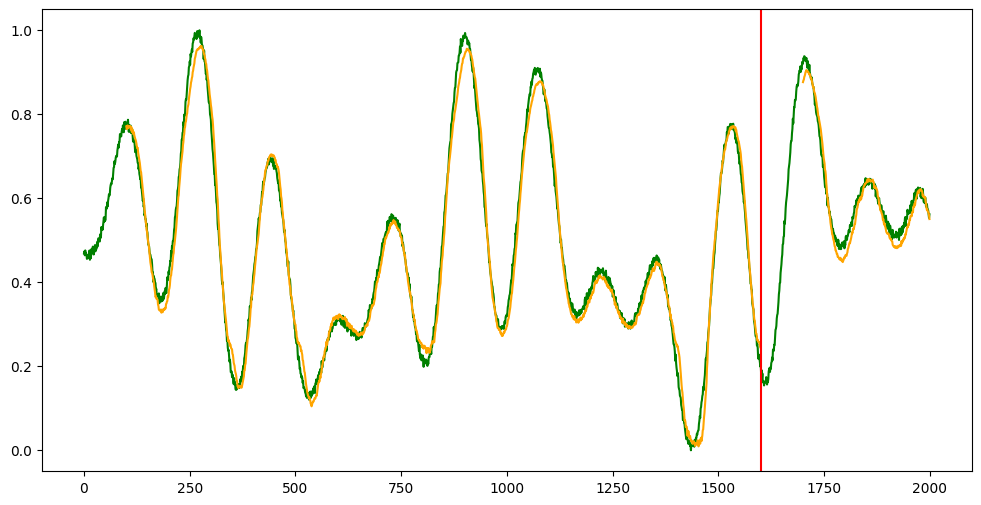

In [12]:
# grafico relativo all'output del modello rispetto
# ai dati reali iniziali
index = df.index.values
plt.figure(figsize=(12, 6))
plt.plot(df, color='green')

x_train_preds = [x for x in range(step, len(train_predict_rnn) + step)]
plt.plot(x_train_preds, train_predict_rnn, color='orange')

x_test_preds = [test_split_point + x + step for x in range(0, len(test_predict_rnn))]
plt.plot(x_test_preds, test_predict_rnn, color='orange')

plt.axvline(df.index[test_split_point], c='r')
plt.show() 

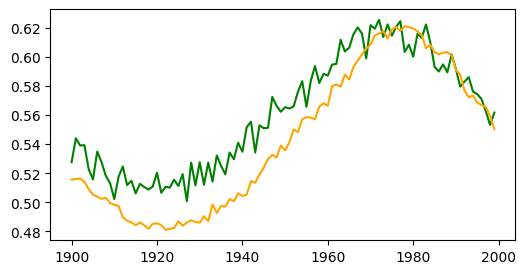

In [13]:
# grafico relativo all'output del modello rispetto
# ai dati reali iniziali - osservazione degli ultimi 100 esempi
plt.figure(figsize=(6, 3))
plt.plot(df[-100:], color='green')
plt.plot(x_test_preds[-100:], test_predict_rnn[-100:], color='orange')
plt.show()

In [14]:
# costruzione del modello tramite celle LSTM
model_lstm = Sequential()
model_lstm.add(LSTM(units=64, input_shape=(step, 1), return_sequences=True))
model_lstm.add(LSTM(units=64, return_sequences=True))
model_lstm.add(LSTM(units=64,))
model_lstm.add(Dense(32, activation="relu"))
model_lstm.add(Dense(32, activation="relu"))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error', optimizer=Nadam(), metrics=['mean_absolute_error'])
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 64)           16896     
                                                                 
 lstm_1 (LSTM)               (None, 100, 64)           33024     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 32)                1056      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 86,113
Trainable params: 86,113
Non-trai

In [15]:
# addestramento del modello basato su celle LSTM
start = timer()
lstm_h = model_lstm.fit(train_x, train_y, epochs=10, batch_size=512, verbose=2)
end = timer()
lstm_t = end - start
print('terminato.')

Epoch 1/10
3/3 - 5s - loss: 0.2623 - mean_absolute_error: 0.4566 - 5s/epoch - 2s/step
Epoch 2/10
3/3 - 1s - loss: 0.1901 - mean_absolute_error: 0.3821 - 1s/epoch - 430ms/step
Epoch 3/10
3/3 - 1s - loss: 0.0575 - mean_absolute_error: 0.1893 - 1s/epoch - 431ms/step
Epoch 4/10
3/3 - 1s - loss: 0.0202 - mean_absolute_error: 0.1158 - 1s/epoch - 433ms/step
Epoch 5/10
3/3 - 1s - loss: 0.0168 - mean_absolute_error: 0.1073 - 1s/epoch - 425ms/step
Epoch 6/10
3/3 - 1s - loss: 0.0147 - mean_absolute_error: 0.1001 - 1s/epoch - 429ms/step
Epoch 7/10
3/3 - 1s - loss: 0.0128 - mean_absolute_error: 0.0933 - 1s/epoch - 434ms/step
Epoch 8/10
3/3 - 1s - loss: 0.0106 - mean_absolute_error: 0.0840 - 1s/epoch - 433ms/step
Epoch 9/10
3/3 - 1s - loss: 0.0083 - mean_absolute_error: 0.0744 - 1s/epoch - 446ms/step
Epoch 10/10
3/3 - 1s - loss: 0.0090 - mean_absolute_error: 0.0759 - 1s/epoch - 437ms/step
terminato.


In [16]:
# analisi del comportamento del modello
train_predict_lstm = model_lstm.predict(train_x)
test_predict_lstm = model_lstm.predict(test_x)

10/10 [==============================] - 0s 35ms/step


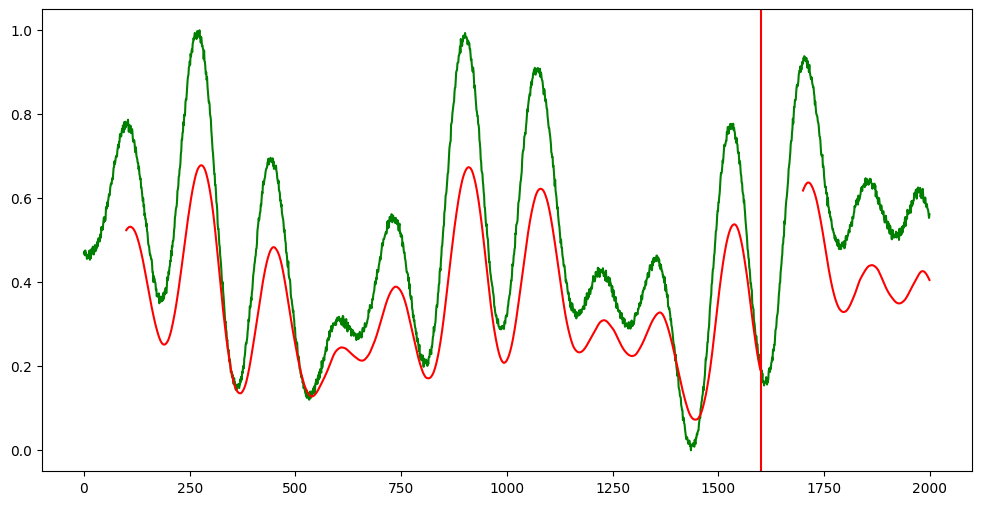

In [17]:
# confronto del comportamento del modello
# rispetto ai dati reali
index = df.index.values
plt.figure(figsize=(12, 6))
plt.plot(df, color='green')

x_train_preds = [x for x in range(step, len(train_predict_lstm) + step)]
plt.plot(x_train_preds, train_predict_lstm, color='red')

x_test_preds = [test_split_point + x + step for x in range(0, len(test_predict_lstm))]
plt.plot(x_test_preds, test_predict_lstm, color='red')

plt.axvline(df.index[test_split_point], c='r')
plt.show()

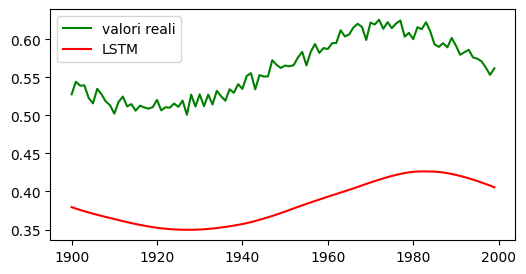

In [18]:
# analisi sugli ultimi 100 esempi predetti rispetto
# ai dati reali iniziali
plt.figure(figsize=(6, 3))
plt.plot(df[-100:], color='green', label='valori reali')
plt.plot(x_test_preds[-100:], test_predict_lstm[-100:], color='red', label='LSTM')
plt.legend()
plt.show()

In [19]:
# costruzione di un modello basato su celle di tipo GRU
model_gru = Sequential()
model_gru.add(GRU(units=64, input_shape=(step, 1), return_sequences=True))
model_gru.add(GRU(units=64, return_sequences=True))
model_gru.add(GRU(units=64))
model_gru.add(Dense(32, activation="relu"))
model_gru.add(Dense(32, activation="relu"))
model_gru.add(Dense(1))
model_gru.compile(loss='mean_squared_error', optimizer=Nadam(), metrics=['mean_absolute_error'])
model_gru.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 100, 64)           12864     
                                                                 
 gru_1 (GRU)                 (None, 100, 64)           24960     
                                                                 
 gru_2 (GRU)                 (None, 64)                24960     
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 32)                1056      
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 65,953
Trainable params: 65,953
Non-trai

In [20]:
# addestramento del modello basato su celle GRU
start = timer()
gru_h = model_gru.fit(train_x, train_y, epochs=10, batch_size=512, verbose=2)
end = timer()
gru_t = end - start
print('terminato.')

Epoch 1/10
3/3 - 5s - loss: 0.2798 - mean_absolute_error: 0.4707 - 5s/epoch - 2s/step
Epoch 2/10
3/3 - 1s - loss: 0.2012 - mean_absolute_error: 0.3932 - 1s/epoch - 371ms/step
Epoch 3/10
3/3 - 1s - loss: 0.1015 - mean_absolute_error: 0.2619 - 1s/epoch - 365ms/step
Epoch 4/10
3/3 - 1s - loss: 0.0190 - mean_absolute_error: 0.1052 - 1s/epoch - 367ms/step
Epoch 5/10
3/3 - 1s - loss: 0.0134 - mean_absolute_error: 0.1013 - 1s/epoch - 367ms/step
Epoch 6/10
3/3 - 1s - loss: 0.0103 - mean_absolute_error: 0.0891 - 1s/epoch - 368ms/step
Epoch 7/10
3/3 - 1s - loss: 0.0080 - mean_absolute_error: 0.0776 - 1s/epoch - 374ms/step
Epoch 8/10
3/3 - 1s - loss: 0.0065 - mean_absolute_error: 0.0692 - 1s/epoch - 391ms/step
Epoch 9/10
3/3 - 1s - loss: 0.0052 - mean_absolute_error: 0.0614 - 1s/epoch - 397ms/step
Epoch 10/10
3/3 - 1s - loss: 0.0039 - mean_absolute_error: 0.0532 - 1s/epoch - 390ms/step
terminato.


In [21]:
# analisi dell'output del modello
train_predict_gru = model_gru.predict(train_x)
test_predict_gru = model_gru.predict(test_x)

10/10 [==============================] - 0s 28ms/step


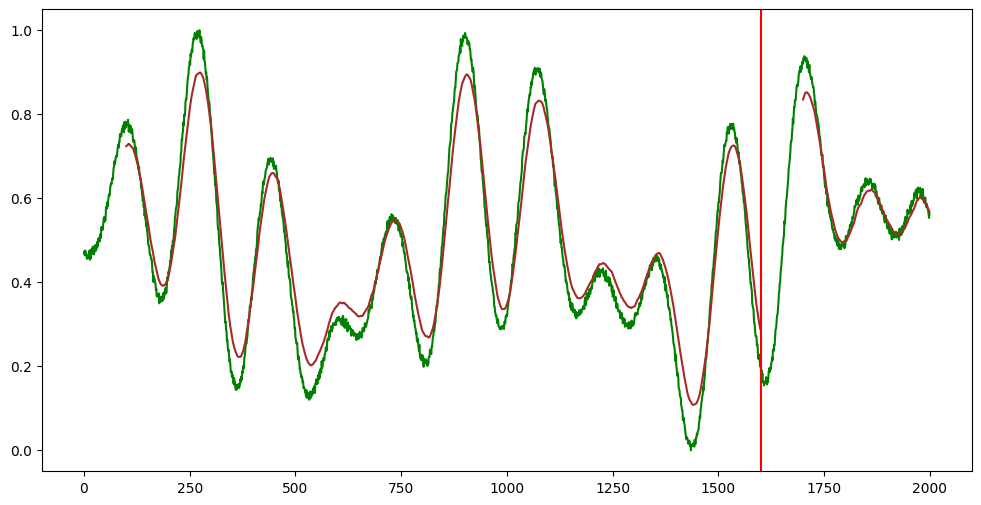

In [22]:
# grafico di confronto dell'output del modello
# rispetto ai dati iniziali
index = df.index.values
plt.figure(figsize=(12, 6))
plt.plot(df, color='green')

x_train_preds = [x for x in range(step, len(train_predict_gru) + step)]
plt.plot(x_train_preds, train_predict_gru, color='brown')

x_test_preds = [test_split_point + x + step for x in range(0, len(test_predict_gru))]
plt.plot(x_test_preds, test_predict_gru, color='brown')

plt.axvline(df.index[test_split_point], c='r')
plt.show()

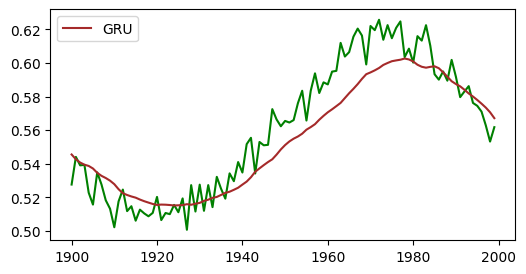

In [23]:
# grafico di dettaglio degli ultimi 100 esempi
# generati dal modello attuale rispetto ai precedenti
plt.figure(figsize=(6, 3))
plt.plot(df[-100:], color='green')
plt.plot(x_test_preds[-100:], test_predict_gru[-100:], color='brown', label='GRU')
plt.legend()
plt.show()

In [24]:
# implementazione di un modello di base di rete ricorrente
model_vanilla = Sequential()
model_vanilla.add(SimpleRNN(units=64, input_shape=(step, 1), activation="relu"))
model_vanilla.add(Dense(32, activation="relu"))
model_vanilla.add(Dense(1))
model_vanilla.compile(loss='mean_squared_error', optimizer=Nadam(), metrics=['mean_absolute_error'])
model_vanilla.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, 64)                4224      
                                                                 
 dense_9 (Dense)             (None, 32)                2080      
                                                                 
 dense_10 (Dense)            (None, 1)                 33        
                                                                 
Total params: 6,337
Trainable params: 6,337
Non-trainable params: 0
_________________________________________________________________


In [25]:
# addestramento della vanilla RNN
start = timer()
vanilla_h = model_vanilla.fit(train_x, train_y, epochs=10, batch_size=512, verbose=2)
end = timer()
vanilla_t = end - start
print('terminato.')

Epoch 1/10
3/3 - 1s - loss: 0.3576 - mean_absolute_error: 0.5330 - 1s/epoch - 382ms/step
Epoch 2/10
3/3 - 0s - loss: 0.2888 - mean_absolute_error: 0.4756 - 151ms/epoch - 50ms/step
Epoch 3/10
3/3 - 0s - loss: 0.2229 - mean_absolute_error: 0.4136 - 143ms/epoch - 48ms/step
Epoch 4/10
3/3 - 0s - loss: 0.1554 - mean_absolute_error: 0.3369 - 139ms/epoch - 46ms/step
Epoch 5/10
3/3 - 0s - loss: 0.0837 - mean_absolute_error: 0.2379 - 139ms/epoch - 46ms/step
Epoch 6/10
3/3 - 0s - loss: 0.0314 - mean_absolute_error: 0.1355 - 139ms/epoch - 46ms/step
Epoch 7/10
3/3 - 0s - loss: 0.0077 - mean_absolute_error: 0.0665 - 141ms/epoch - 47ms/step
Epoch 8/10
3/3 - 0s - loss: 0.0049 - mean_absolute_error: 0.0614 - 139ms/epoch - 46ms/step
Epoch 9/10
3/3 - 0s - loss: 0.0040 - mean_absolute_error: 0.0550 - 140ms/epoch - 47ms/step
Epoch 10/10
3/3 - 0s - loss: 0.0024 - mean_absolute_error: 0.0422 - 137ms/epoch - 46ms/step
terminato.


In [26]:
# validazione della vanilla RNN
train_predict_vanilla = model_vanilla.predict(train_x)
test_predict_vanilla = model_vanilla.predict(test_x)

10/10 [==============================] - 0s 5ms/step


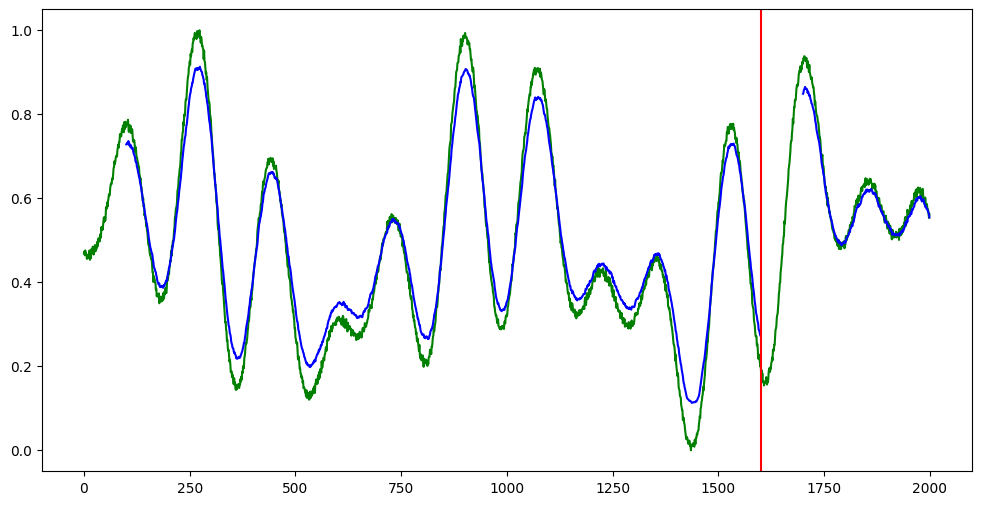

In [27]:
# grafico del confronto tra valori
# predetti e valori reali
index = df.index.values
plt.figure(figsize=(12, 6))
plt.plot(df, color='green')

x_train_preds = [x for x in range(step, len(train_predict_vanilla) + step)]
plt.plot(x_train_preds, train_predict_vanilla, color='blue')

x_test_preds = [test_split_point + x + step for x in range(0, len(test_predict_vanilla))]
plt.plot(x_test_preds, test_predict_vanilla, color='blue')

plt.axvline(df.index[test_split_point], c='r')
plt.show()

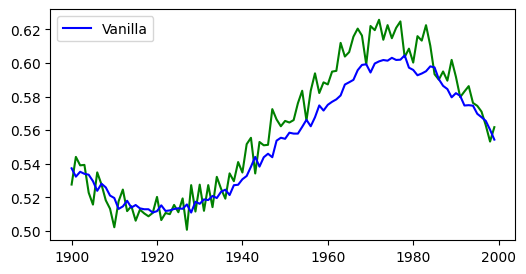

In [28]:
# confronto tra tutti i modelli creati e i dati reali
# per gli ultimi 100 esempi
plt.figure(figsize=(6, 3))
plt.plot(df[-100:], color='green')
plt.plot(x_test_preds[-100:], test_predict_vanilla[-100:], color='blue', label='Vanilla')
plt.legend()
plt.show()

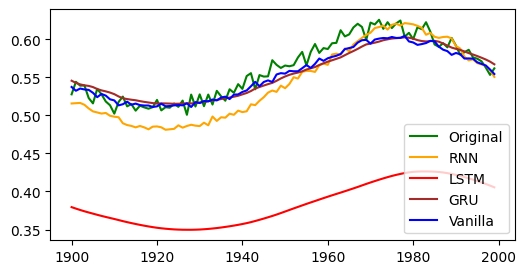

In [29]:
# confronto tra tutti i modelli creati e i dati reali
# per gli ultimi 100 esempi
plt.figure(figsize=(6, 3))
plt.plot(df[-100:], color='green', label='Original')
plt.plot(x_test_preds[-100:], test_predict_rnn[-100:], color='orange', label='RNN')
plt.plot(x_test_preds[-100:], test_predict_lstm[-100:], color='red', label='LSTM')
plt.plot(x_test_preds[-100:], test_predict_gru[-100:], color='brown', label='GRU')
plt.plot(x_test_preds[-100:], test_predict_vanilla[-100:], color='blue', label='Vanilla')
plt.legend()
plt.show()

<Figure size 2000x1200 with 0 Axes>

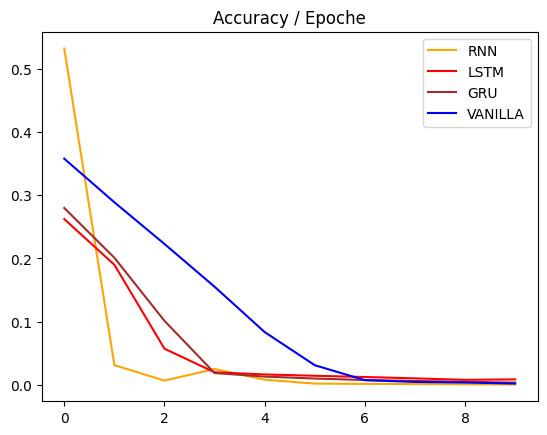

In [30]:
# andamento della Loss tra i vari modelli
plt.figure(figsize=(20,12))
f, ax = plt.subplots()
ax.set_title('Accuracy / Epoche')
ax.plot(rnn_h.history['loss'], color='orange')
ax.plot(lstm_h.history['loss'], color='red')
ax.plot(gru_h.history['loss'], color='brown')
ax.plot(vanilla_h.history['loss'], color='blue')
ax.legend(['RNN', 'LSTM', 'GRU', 'VANILLA'], loc = 0)
plt.show() 

<Figure size 2000x1200 with 0 Axes>

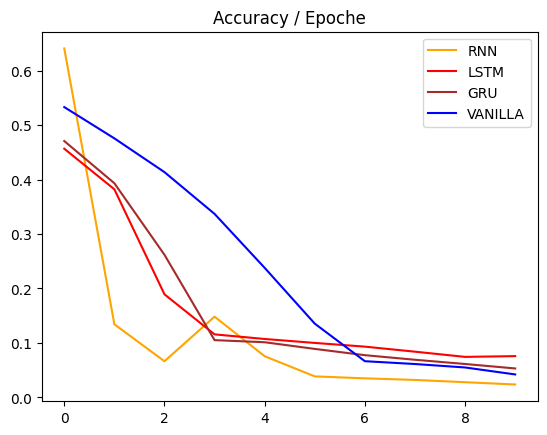

In [31]:
# andamento della Mean Absolute Error tra i vari modelli
plt.figure(figsize=(20,12))
f, ax = plt.subplots()
ax.set_title('Accuracy / Epoche')
ax.plot(rnn_h.history['mean_absolute_error'], color='orange')
ax.plot(lstm_h.history['mean_absolute_error'], color='red')
ax.plot(gru_h.history['mean_absolute_error'], color='brown')
ax.plot(vanilla_h.history['mean_absolute_error'], color='blue')
ax.legend(['RNN', 'LSTM', 'GRU', 'VANILLA'], loc = 0)
plt.show() 

In [32]:
print('          loss      mae     time')
print('LSTM    ', str(lstm_h.history['loss'][len(lstm_h.history['loss'])-1])[:5], '  ', str(lstm_h.history['mean_absolute_error'][len(lstm_h.history['mean_absolute_error'])-1])[:5],
      '   ' + str(lstm_t)[:5])
print('GRU     ', str(gru_h.history['loss'][len(gru_h.history['loss'])-1])[:5], '  ', str(gru_h.history['mean_absolute_error'][len(gru_h.history['mean_absolute_error'])-1])[:5],
      '   ' + str(gru_t)[:5])
print('RNN     ', str(rnn_h.history['loss'][len(rnn_h.history['loss'])-1])[:5], '  ', str(rnn_h.history['mean_absolute_error'][len(rnn_h.history['mean_absolute_error'])-1])[:5],
      '    ' + str(rnn_t)[:4])
print('VANILLA ', str(vanilla_h.history['loss'][len(vanilla_h.history['loss'])-1])[:5], '  ', 
      str(vanilla_h.history['mean_absolute_error'][len(vanilla_h.history['mean_absolute_error'])-1])[:5], '    ' + str(vanilla_t)[:4])

          loss      mae     time
LSTM     0.008    0.075    17.12
GRU      0.003    0.053    15.40
RNN      0.000    0.023     7.05
VANILLA  0.002    0.042     2.47
